<a href="https://colab.research.google.com/github/karensanb/rx/blob/main/segundo_corte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade pip
!pip install medmnist==2.2.2 timm==0.9.2 torch torchvision matplotlib seaborn
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-96477ydt
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-96477ydt
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import medmnist
from medmnist import INFO
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

print("Librerías cargadas correctamente")


Librerías cargadas correctamente


In [ ]:
DATA_FLAG = 'organamnist'
EPOCHS = 20
BATCH_SIZE = 64
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Dispositivo:", DEVICE)

Dispositivo: cuda


In [ ]:
DATA_FLAG = "organamnist"

info = INFO[DATA_FLAG]
DataClass = getattr(medmnist, info['python_class'])

import numpy as np

def transform(x):
    x = np.array(x).astype(np.float32) / 255.0  # PIL -> numpy -> escala 0-1
    x = np.stack([x, x, x], axis=0)  # 1 canal -> 3 (RGB)
    return torch.tensor(x)

train_ds = DataClass(split='train', transform=transform, download=True)
val_ds   = DataClass(split='val', transform=transform, download=True)
test_ds  = DataClass(split='test', transform=transform, download=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(info["label"])
print("Dataset cargado correctamente:", DATA_FLAG)
print("Clases:", info["label"])


Dataset cargado correctamente: organamnist
Clases: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}


In [ ]:
class EfficientNetOrgan(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b0", pretrained=True, num_classes=0)
        self.fc = nn.Linear(self.backbone.num_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return self.fc(x)

model = EfficientNetOrgan(NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
print("Modelo EfficientNet listo.")


Modelo EfficientNet listo.


In [ ]:
import time
from sklearn.metrics import accuracy_score

def eval_epoch(loader):
    model.eval()
    preds, trues, losses = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE), yb.squeeze().long().to(DEVICE)
            out = model(xb)
            loss = criterion(out, yb).item()
            losses.append(loss)
            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(yb.cpu().numpy())
    return accuracy_score(trues, preds), sum(losses)/len(losses)

for epoch in range(EPOCHS):
    start = time.time()

    # ---- Entrenamiento ----
    model.train()
    train_losses = []
    train_preds, train_trues = [], []
    for xb, yb in train_loader:
        xb, yb = xb.to(DEVICE), yb.squeeze().long().to(DEVICE)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_preds.extend(out.argmax(1).cpu().numpy())
        train_trues.extend(yb.cpu().numpy())

    train_acc = accuracy_score(train_trues, train_preds)
    train_loss = sum(train_losses)/len(train_losses)

    # ---- Validación ----
    val_acc, val_loss = eval_epoch(val_loader)

    # ---- Tiempo ----
    epoch_time = time.time() - start

    print(f"Epoch {epoch+1}/{EPOCHS}  {int(epoch_time)}s/epoch - accuracy: {train_acc:.4f} - loss: {train_loss:.4f}  - val_accuracy: {val_acc:.4f} - val_loss: {val_loss:.4f}")



Epoch 1/20  19s/epoch - accuracy: 0.7171 - loss: 0.9067  - val_accuracy: 0.9549 - val_loss: 0.1903
Epoch 2/20  19s/epoch - accuracy: 0.9323 - loss: 0.2139  - val_accuracy: 0.9721 - val_loss: 0.0969
Epoch 3/20  23s/epoch - accuracy: 0.9681 - loss: 0.0996  - val_accuracy: 0.9732 - val_loss: 0.0815
Epoch 4/20  19s/epoch - accuracy: 0.9824 - loss: 0.0549  - val_accuracy: 0.9743 - val_loss: 0.0823
Epoch 5/20  19s/epoch - accuracy: 0.9888 - loss: 0.0358  - val_accuracy: 0.9766 - val_loss: 0.0697
Epoch 6/20  19s/epoch - accuracy: 0.9917 - loss: 0.0262  - val_accuracy: 0.9763 - val_loss: 0.0878
Epoch 7/20  21s/epoch - accuracy: 0.9947 - loss: 0.0188  - val_accuracy: 0.9803 - val_loss: 0.0611
Epoch 8/20  19s/epoch - accuracy: 0.9948 - loss: 0.0181  - val_accuracy: 0.9800 - val_loss: 0.0657
Epoch 9/20  19s/epoch - accuracy: 0.9957 - loss: 0.0144  - val_accuracy: 0.9800 - val_loss: 0.0687
Epoch 10/20  20s/epoch - accuracy: 0.9965 - loss: 0.0119  - val_accuracy: 0.9821 - val_loss: 0.0667
Epoch 11/

In [ ]:
test_preds, test_trues = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(DEVICE), yb.squeeze().long().to(DEVICE)
        out = model(xb)
        test_preds.extend(out.argmax(1).cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

print("Accuracy en Test:", accuracy_score(test_trues, test_preds))
print("\nReporte de Clasificación:")
print(classification_report(test_trues, test_preds, zero_division=0))


Accuracy en Test: 0.9203509956125548

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.95      0.90      0.92       784
           2       0.90      0.92      0.91       793
           3       0.99      0.92      0.95       785
           4       0.81      0.79      0.80      2064
           5       0.89      0.87      0.88      1965
           6       0.98      0.99      0.98      3285
           7       0.97      1.00      0.98      1747
           8       1.00      0.97      0.99      1813
           9       0.91      0.92      0.91      1622
          10       0.88      0.90      0.89      1884

    accuracy                           0.92     17778
   macro avg       0.92      0.92      0.92     17778
weighted avg       0.92      0.92      0.92     17778



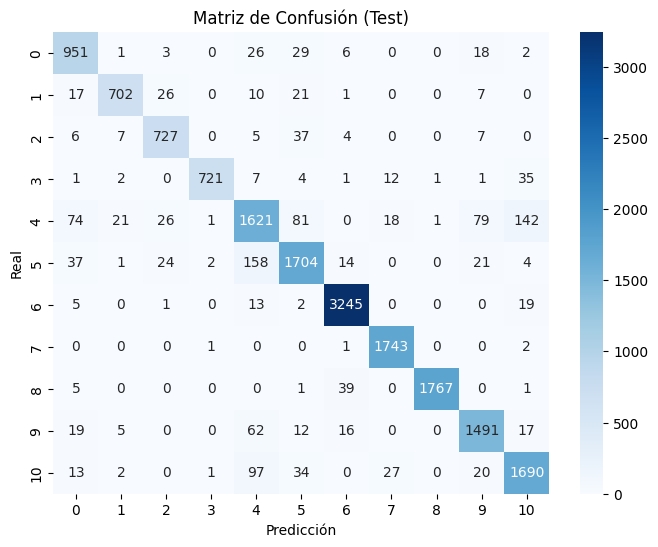

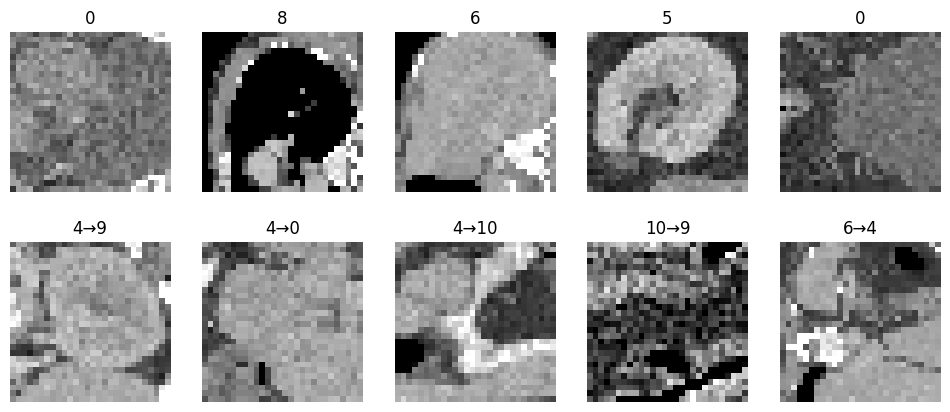

In [ ]:
cm = confusion_matrix(test_trues, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión (Test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

correct_idx = [i for i in range(len(test_preds)) if test_preds[i] == test_trues[i]][:5]
wrong_idx   = [i for i in range(len(test_preds)) if test_preds[i] != test_trues[i]][:5]

plt.figure(figsize=(12,5))
for i, idx in enumerate(correct_idx):
    img = test_ds[idx][0].permute(1,2,0).numpy()
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(f"{test_preds[idx]}")
    plt.axis('off')

for i, idx in enumerate(wrong_idx):
    img = test_ds[idx][0].permute(1,2,0).numpy()
    plt.subplot(2,5,i+6)
    plt.imshow(img)
    plt.title(f"{test_trues[idx]}→{test_preds[idx]}")
    plt.axis('off')

plt.show()


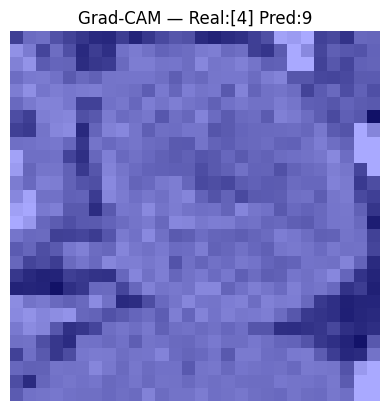

In [ ]:
target_layer = model.backbone.conv_head
cam = GradCAM(model=model, target_layers=[target_layer])

idx = wrong_idx[0]  # ejemplo de incorrecta
img_tensor, label = test_ds[idx]
img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(int(test_preds[idx]))])[0]
rgb = img_tensor.squeeze().permute(1,2,0).cpu().numpy()
visualization = show_cam_on_image(rgb, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title(f"Grad-CAM — Real:{label} Pred:{test_preds[idx]}")
plt.axis('off')
plt.show()

/tmp/ipython-input-1229279681.py:63: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)  # Normalizar
/tmp/ipython-input-1229279681.py:64: RuntimeWarning: invalid value encountered in cast
  cam = np.uint8(cam * 255)


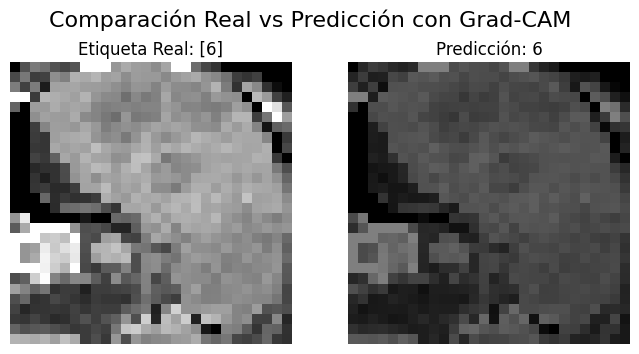

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

# aplicar Grad-CAM
def grad_cam(model, img_tensor, target_class, layer_name):
    model.eval()

    gradients = []
    activations = []

    def save_gradients(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def save_activations(module, input, output):
        activations.append(output)

    # Registrar hooks en la última capa convolucional
    # Find the target layer by name
    target_layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            target_layer = module
            break

    if target_layer is None:
        raise ValueError(f"Layer '{layer_name}' not found in the model.")

    hook_grad = target_layer.register_backward_hook(save_gradients)
    hook_act = target_layer.register_forward_hook(save_activations)


    img_input = img_tensor.unsqueeze(0).to(next(model.parameters()).device)

    # Forward
    output = model(img_input)
    if isinstance(target_class, int):
        target = output[0, target_class]
    else:
        target = output[0, output.argmax()]

    # Backward
    model.zero_grad()
    target.backward()

    # Remove hooks
    hook_grad.remove()
    hook_act.remove()

    # Grad-CAM
    grads = gradients[0].cpu().data.numpy()[0]
    acts = activations[0].cpu().data.numpy()[0]

    weights = np.mean(grads, axis=(1,2))
    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)  # Normalizar
    cam = np.uint8(cam * 255)
    cam = np.stack([cam]*3, axis=-1)  # Convertir a 3 canales
    cam = np.transpose(cam, (1,0,2))
    return cam

# imagen al azar
idx = random.randint(0, len(test_ds)-1)
img_tensor, label_real = test_ds[idx]

# Predicción
model.eval()
with torch.no_grad():
    pred = model(img_tensor.unsqueeze(0).to(next(model.parameters()).device)).argmax(1).item()

# Imagen original
img_np = img_tensor.permute(1,2,0).numpy()

# Generar Grad-CAM
cam = grad_cam(model, img_tensor, pred, layer_name='backbone.conv_head')  # <- Corrected layer name

# Mezclar imagen original con Grad-CAM
cam_img = 0.5*img_np + 0.5*(cam/255)


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img_np, cmap='gray')
plt.title(f"Etiqueta Real: {label_real}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cam_img, cmap='jet')
plt.title(f"Predicción: {pred}")
plt.axis('off')

plt.suptitle("Comparación Real vs Predicción con Grad-CAM", fontsize=16)
plt.show()